In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime as dt
from pandas.tseries.offsets import DateOffset
import seaborn as sns
from pandas.tseries.offsets import MonthEnd

## Data from sentiment analysis

In [4]:
sentiment_df = pd.read_csv('./data/sentiment_df.csv')
sentiment_df.head()

,Unnamed: 0,quoteID,quotation,speaker,date,numOccurrences,neg,neu,pos,compound,date_clean
0,0,2015-01-01-041284,With major new premium services from Apple and...,Geoff Taylor,2015-01-01 00:01:00,3,0.0,0.854,0.146,0.5859,2015-01-01
1,1,2015-01-01-032875,They realize that they just can't assume that ...,Angus King,2015-01-01 00:14:24,1,0.0,0.892,0.108,0.6369,2015-01-01
2,2,2015-01-01-036563,We feel that there are a substantial number of...,William Anderson,2015-01-01 01:30:18,1,0.0,0.795,0.205,0.2732,2015-01-01
3,3,2015-01-01-041777,You can play a murderer's row but in conferenc...,Jim Crews,2015-01-01 02:47:17,1,0.0,0.769,0.231,0.5859,2015-01-01
4,4,2015-01-01-039665,"We've also, surprisingly, had a lot of Apple r...",Daniel Williams,2015-01-01 04:10:31,1,0.0,0.804,0.196,0.2960,2015-01-01


## Monthly sentiment

In [10]:
 # Based on how much they contribute increase size of scatter plot circle
agg_month_sentiment = []
agg_month_dates = []

for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_month = date[:7]
        current_size = 0

    tmp_month = current_month
    current_month = date[:7] # the seven first digits of the date
    if tmp_month != current_month:
        agg_month_sentiment.append(current_size)
        current_size = 0
        agg_month_dates.append(current_month)

    # updates weighted aggregated value of positive and negative
    current_size += row['compound']*row['numOccurrences']

result_values = []
result_mon = []
for mon, agg in zip(agg_month_dates, agg_month_sentiment):
    result_values.append(agg)
    result_mon.append(mon)

We create a monthly aggregated sentiment dataframe that will be useful later when merging stock data and sentiment data.

In [16]:
sentiment_monthly_df = pd.DataFrame(zip(result_mon, result_values), columns =['Date', 'Sentiment_score'])
sentiment_monthly_df['Date'] = sentiment_monthly_df['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m'))
sentiment_monthly_df.head()

,Date,Sentiment_score
0,2015-02-01,1142.3663
1,2015-03-01,788.0255
2,2015-04-01,1894.8802
3,2015-05-01,1344.7904
4,2015-06-01,815.1817


### Weekly sentiment

In [19]:
agg_week_sentiment_weekly = []
agg_week_dates_weekly = []
day_counter_weekly = 0
for index, (idx, row) in enumerate(sentiment_df.iterrows()):
    date = row['date_clean']
    if index == 0:
        current_day_weekly = date[:10]
        current_size_weekly = 0


    tmp_day_weekly = current_day_weekly
    current_day_weekly = date[:10] # the seven first digits of the date
    if tmp_day_weekly != current_day_weekly:
        day_counter_weekly += 1
    if day_counter_weekly == 7:
        agg_week_sentiment_weekly.append(current_size_weekly)
        agg_week_dates_weekly.append(current_day_weekly)
        current_size_weekly = 0
        day_counter_weekly = 0

    # updates weighted aggregated value of positive and negative
    current_size_weekly += row['compound']*row['numOccurrences']


result_week_values = []
result_week = []
for week, agg in zip(agg_week_dates_weekly, agg_week_sentiment_weekly):
    result_week_values.append(agg)
    result_week.append(week)

In [21]:
sentiment_weekly_df=pd.DataFrame(zip(result_week, result_week_values), columns =['Date', 'Sentiment_score'])
sentiment_weekly_df['Date'] = pd.to_datetime(sentiment_weekly_df['Date'])

sentiment_weekly_df

,Date,Sentiment_score
0,2015-01-08,88.4621
1,2015-01-15,176.8740
2,2015-01-22,158.2463
3,2015-01-29,604.9199
4,2015-02-05,211.2495
...,...,...
257,2020-03-19,260.1892
258,2020-03-26,112.9602
259,2020-04-02,21.0550
260,2020-04-09,58.1694


## Get data from stock analysis

In [23]:
stock_data=pd.read_csv('./data/AAPL_2015_to_2020_yahoo_finance.csv')
apple_event_and_stock_data=pd.read_csv('./data/events_dates_with_stock_data.csv')
apple_earnings_and_stock_data=pd.read_csv('./data/earnings_dates_with_stock_data.csv')

Remove stock data from after 16-04-2020 due to the lack of sentiment data after that date.

In [24]:
stock_data=stock_data[~(stock_data['Date'] > '2020-04-16')]

### Group by week

In [28]:
stock_data_weekly_average=stock_data.copy()

#Create a new dataframe containing the weekly average of the stock price. The method is obtained from
stock_data_weekly_average.Date = pd.to_datetime(stock_data_weekly_average.Date) - pd.to_timedelta(7, unit='d')
stock_data_weekly_average = stock_data_weekly_average.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().reset_index().sort_values('Date')

In [29]:
stock_data_weekly_average

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-29,27.460000,27.511251,26.595000,26.947500,24.397426,2.349802e+08
1,2015-01-05,27.412000,27.683000,26.952000,27.358000,24.769084,2.148942e+08
2,2015-01-12,27.343750,27.558125,26.829375,27.051875,24.491926,2.545758e+08
3,2015-01-19,27.654500,28.030500,27.441000,27.837500,25.203208,2.034816e+08
4,2015-01-26,29.141000,29.448001,28.641500,28.957000,26.216769,3.783734e+08
...,...,...,...,...,...,...,...
272,2020-03-16,60.496500,62.038999,57.936999,59.896000,59.159392,3.269186e+08
273,2020-03-23,61.856000,63.800500,61.070500,62.669501,61.898788,2.430827e+08
274,2020-03-30,61.807000,63.258498,60.819000,62.200500,61.435554,1.741710e+08
275,2020-04-06,66.909374,67.677502,65.672501,66.671250,65.851320,1.661600e+08


### Calculate monthly change

In [32]:
stock_data["Date"]=stock_data['Date'].apply(lambda x: dt.datetime.strptime(x[:10], '%Y-%m-%d'))

In [35]:
monthly_open_prize=stock_data.groupby(pd.Grouper(key='Date', freq='M')).first()['Open']
monthly_close_price=stock_data.groupby(pd.Grouper(key='Date', freq='M')).last()['Close']

monthly_stock_diff_df=pd.DataFrame(((monthly_close_price-monthly_open_prize)/monthly_open_prize)*100, columns=['price_difference'])

In [36]:
monthly_stock_diff_df.head()

,price_difference
Date,
2015-01-31,5.180002
2015-02-28,8.818300
2015-03-31,-3.729207
2015-04-30,0.264381
2015-05-31,3.314830


`monthly_stock_diff` displays the monthly price change off the Apple-stock.

## See if there is any correlation between stock and sentiment (Months)

As the `sentiment_monthly_df` use the first date of the next month used to calculate sentiment while `monthly_stock_diff` use the last day of the month used to calculate stock difference we change the date of `sentiment_monthly_df` by one day before merging them.

In [40]:
sentiment_monthly_df['Date']=sentiment_monthly_df['Date']-DateOffset(days=1)

In [41]:
sentiment_monthly_df.head()

,Date,Sentiment_score
0,2015-01-31,1142.3663
1,2015-02-28,788.0255
2,2015-03-31,1894.8802
3,2015-04-30,1344.7904
4,2015-05-31,815.1817


 We then plot the development of the stock price and the development of the sentiment to see if there is any obvious relationships between the two.

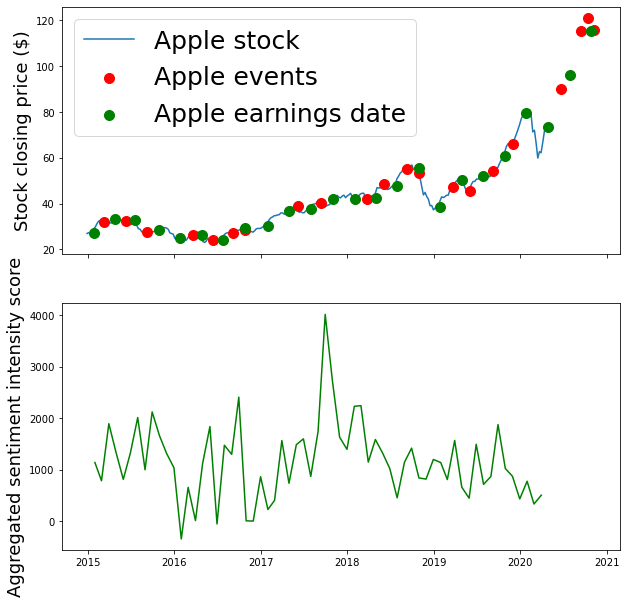

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,10))
ax1.plot(stock_data_weekly_average.Date, stock_data_weekly_average.Close, label='Apple stock')
ax1.set_ylabel('Stock closing price ($)', size=18)
ax1.scatter(apple_event_and_stock_data.Date, apple_event_and_stock_data.Close, c='r', s=100, zorder=3, label='Apple events')
ax1.scatter(apple_earnings_and_stock_data.Date, apple_earnings_and_stock_data.Close, c='g', s=100, zorder=3, label='Apple earnings date')
ax1.legend(prop={'size': 25})

ax2.plot(sentiment_monthly_df.Date, sentiment_monthly_df.Sentiment_score, color='green')
ax2.set_ylabel('Aggregated sentiment intensity score', fontsize=18)
plt.show();

 By just looking at the graphs it is hard to tell if the sentiment and the stock price is related in any way. We therefore tries to merge the two dataframes by the Date-column to further explore the relationships between the sentiment and price.

In [58]:
stock_price_sentiment = pd.merge(monthly_stock_diff_df, sentiment_monthly_df, how='inner', on = 'Date')

In [59]:
stock_price_sentiment.head()

,Date,price_difference,Sentiment_score
0,2015-01-31,5.180002,1142.3663
1,2015-02-28,8.818300,788.0255
2,2015-03-31,-3.729207,1894.8802
3,2015-04-30,0.264381,1344.7904
4,2015-05-31,3.314830,815.1817


Text(0, 0.5, 'Sentiment score')

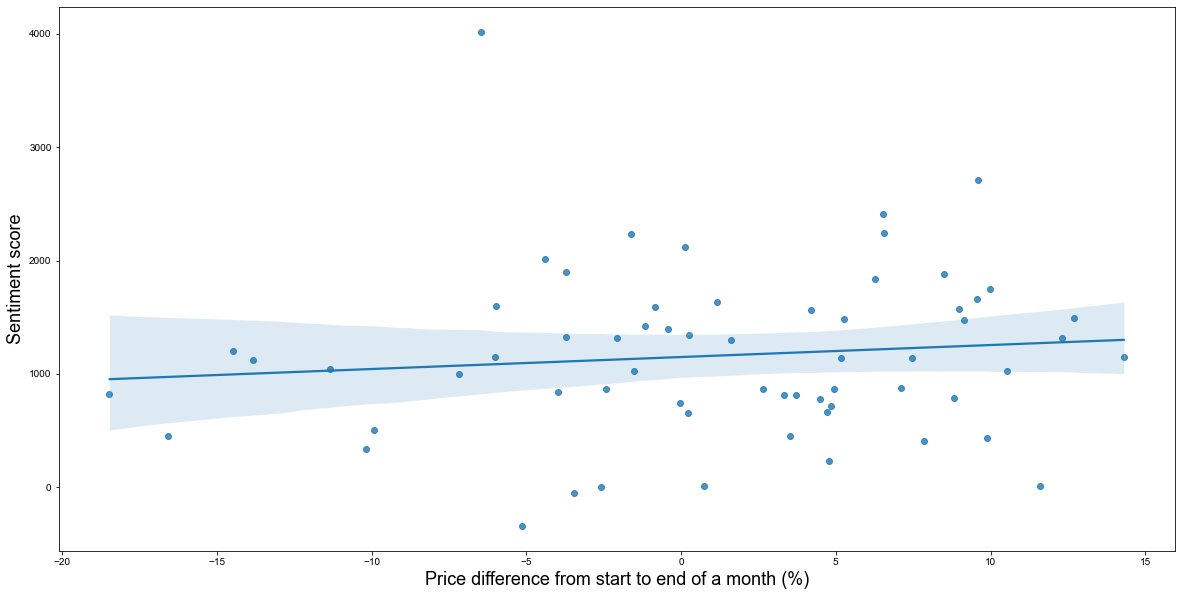

In [66]:
fig, ax=plt.subplots(figsize=(20,10))
sns.set_theme(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False}, font_scale=2)
sns.set(font_scale=2)
ax=sns.regplot(x=stock_price_sentiment.price_difference, y=stock_price_sentiment.Sentiment_score)
ax.set_xlabel('Price difference from start to end of a month (%)', size=18)
ax.set_ylabel('Sentiment score', size=18)

By looking at the correlation between the stock price and the sentiment score we see a slightly positive relationship. From this it might seem that in months where the Apple stock gets a lot of postive media attention the stock is more likely to rise. However these findings are not very useful when trying to predict future stock prices because we would not know the sentiment before the end of the month.

## Stock predicting model

We see a slightly positive relationship by looking at the correlation between the stock price and the sentiment score. From this it might seem that in months where the Apple stock gets a lot of positive media attention it is more likely to rise. However these findings are not very useful when predicting future stock prices because we would not know the sentiment before the end of the month.

In [69]:

sentiment_shifted_back_df=sentiment_monthly_df.copy()

#Shifts the date one month back in time
sentiment_shifted_back_df['Date']=sentiment_shifted_back_df['Date']-DateOffset(months=1, days=5)+MonthEnd(1)

#Merge the sentiment_shifted_df with the monthly_stock_diff_df. Each row then represent the sentiment for previous month
#and the stock_price for this month
stock_price_shifted_back_sentiment=pd.merge(monthly_stock_diff_df, sentiment_shifted_back_df, how='inner', on = 'Date')

As we can see from the graph the relationship between the sentiment for the previous month and the price for this month is negative. This correlation is the opposite of what we found for the graph plotting sentiment and stock price for the same month. Based on this we can expect that a stock is more likely to increase in price following a month where we have seen a low sentiment score and vice versa. One explanation for this is that people may sell after a month with increased stock prices to secure profits. Thus the following month even though a stock gets good media attention it will fall.

In [70]:
stock_price_shifted_back_sentiment

,Date,price_difference,Sentiment_score
0,2015-01-31,5.180002,788.0255
1,2015-02-28,8.818300,1894.8802
2,2015-03-31,-3.729207,1344.7904
3,2015-04-30,0.264381,815.1817
4,2015-05-31,3.314830,1326.5021
...,...,...,...
57,2019-10-31,10.525609,875.8196
58,2019-11-30,7.097062,435.4783
59,2019-12-31,9.870171,778.2848
60,2020-01-31,4.479482,337.1790


#### Want to see if plotting a boxplot gives some new foundings

In [72]:
#stock_price_shifted_back_sentiment[\A\]=stock_price_shifted_back_sentiment.groupby(stock_price_shifted_back_sentiment[\price_difference\] np.arange(-20 5 15))
stock_price_shifted_back_sentiment['Category']=0

stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference']<=-15, 'Category'] = 1
stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference'].between(-15,-10), 'Category'] = 2
stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference'].between(-10,-5), 'Category'] = 3
stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference'].between(-5,0), 'Category'] = 4
stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference'].between(0,5), 'Category'] = 5
stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference'].between(5,10), 'Category'] = 6
stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference'].between(10,15), 'Category'] = 7
stock_price_shifted_back_sentiment.loc[stock_price_shifted_back_sentiment['price_difference']>=15, 'Category'] = 8


#stock_price_shifted_back_sentiment.groupby([stock_price_shifted_back_sentiment.Sentiment_scorepd.cut(stock_price_shifted_back_sentiment.price_difference[-20-15-10-505101520])])
#ax = sns.boxplot(x=\ahsha\ y=\Sentiment_score\ data=grouped)

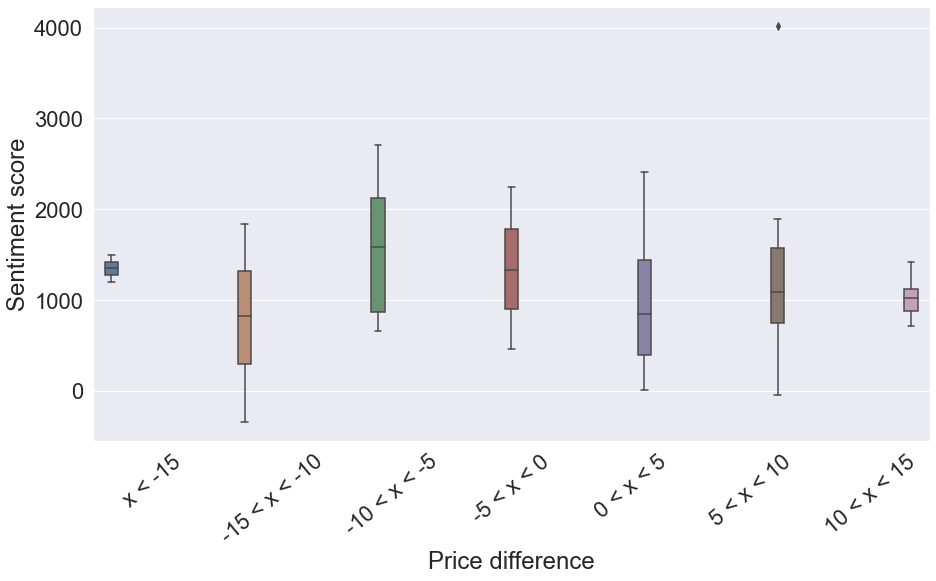

In [74]:
fig, ax = plt.subplots(figsize=(15,8))
sns.set(font_scale=2)
sns.set_theme(style='white', rc={'axes.spines.right': False, 'axes.spines.top': False}, font_scale=2)
plot=sns.boxplot(x='Category', y='Sentiment_score', data=stock_price_shifted_back_sentiment, hue='Category', saturation=0.5)
plt.legend([],[], frameon=False)           
ax.set_ylabel('Sentiment score')
ax.set_xlabel('Price difference')
positions = (0, 1, 2, 3, 4, 5, 6,)
labels = ('x < -15', '-15 < x < -10', '-10 < x < -5', '-5 < x < 0', '0 < x < 5', '5 < x < 10', '10 < x < 15')
plt.xticks(positions, labels, rotation=40);

### Are stock pickers just to late to the party?

 As we have seen above the apple stock tend to fall the month following one with high sentiment scores. Another interesting question to look into is if a stock rises more before it gets all the media i.e. that people just hear the good news when it is already to late. Therefore we want to see the correlation between the stock price and its sentiment score the following month.

In [75]:
sentiment_shifted_forward_df=sentiment_monthly_df.copy()
sentiment_shifted_forward_df

,Date,Sentiment_score
0,2015-01-31,1142.3663
1,2015-02-28,788.0255
2,2015-03-31,1894.8802
3,2015-04-30,1344.7904
4,2015-05-31,815.1817
...,...,...
58,2019-11-30,875.8196
59,2019-12-31,435.4783
60,2020-01-31,778.2848
61,2020-02-29,337.1790


In [77]:
#Shifts the date one month forwards
sentiment_shifted_forward_df['Date']=sentiment_shifted_forward_df['Date']+DateOffset(days=5)+MonthEnd(1)

In [79]:
stock_price_shifted_forward_sentiment=pd.merge(monthly_stock_diff_df, sentiment_shifted_forward_df, how='inner', on = 'Date')

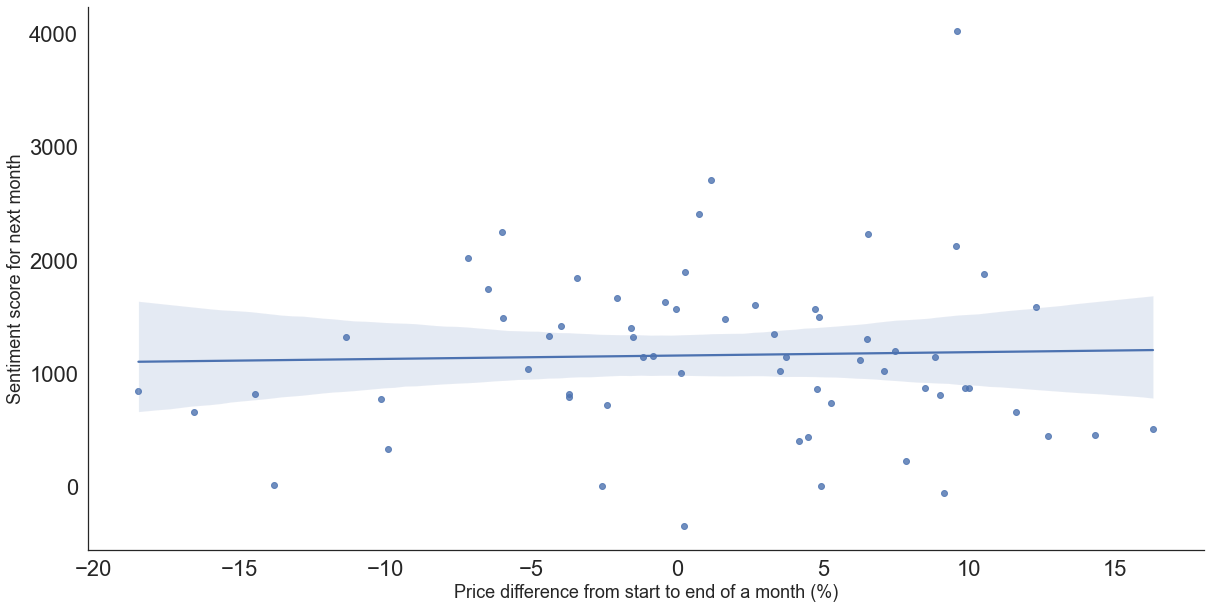

In [81]:
fig, ax=plt.subplots(figsize=(20,10))
ax=sns.regplot(x=stock_price_shifted_forward_sentiment.price_difference, y=stock_price_shifted_forward_sentiment.Sentiment_score)
ax.set_xlabel('Price difference from start to end of a month (%)', size=18)
ax.set_ylabel('Sentiment score for next month', size=18);

## Stock Volume and sentiment

Average stock volume for each month.

In [83]:
monthly_stock_mean=stock_data.groupby(pd.Grouper(key='Date', freq='M')).mean()

In [84]:
stock_mean_sentiment = pd.merge(monthly_stock_mean, sentiment_monthly_df, how='inner', on = 'Date')

In [85]:
stock_mean_sentiment

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment_score
0,2015-01-31,27.791000,28.063500,27.333000,27.660375,25.042844,2.610527e+08,1142.3663
1,2015-02-28,31.255921,31.536185,31.007763,31.358026,28.485852,2.392706e+08,788.0255
2,2015-03-31,31.616591,31.859091,31.246477,31.492727,28.625065,2.070258e+08,1894.8802
3,2015-04-30,31.883810,32.105595,31.556191,31.822857,28.925133,1.897401e+08,1344.7904
4,2015-05-31,32.176875,32.442750,31.915750,32.190375,29.357273,1.908304e+08,815.1817
...,...,...,...,...,...,...,...,...
58,2019-11-30,65.423499,65.865375,65.060500,65.630126,64.631631,8.966630e+07,875.8196
59,2019-12-31,68.847857,69.470952,68.467024,69.131428,68.119577,1.137521e+08,435.4783
60,2020-01-31,77.792738,78.581547,77.207857,77.979048,76.837697,1.397319e+08,778.2848
61,2020-02-29,77.578421,78.813158,76.681579,77.817631,76.821414,1.589094e+08,337.1790


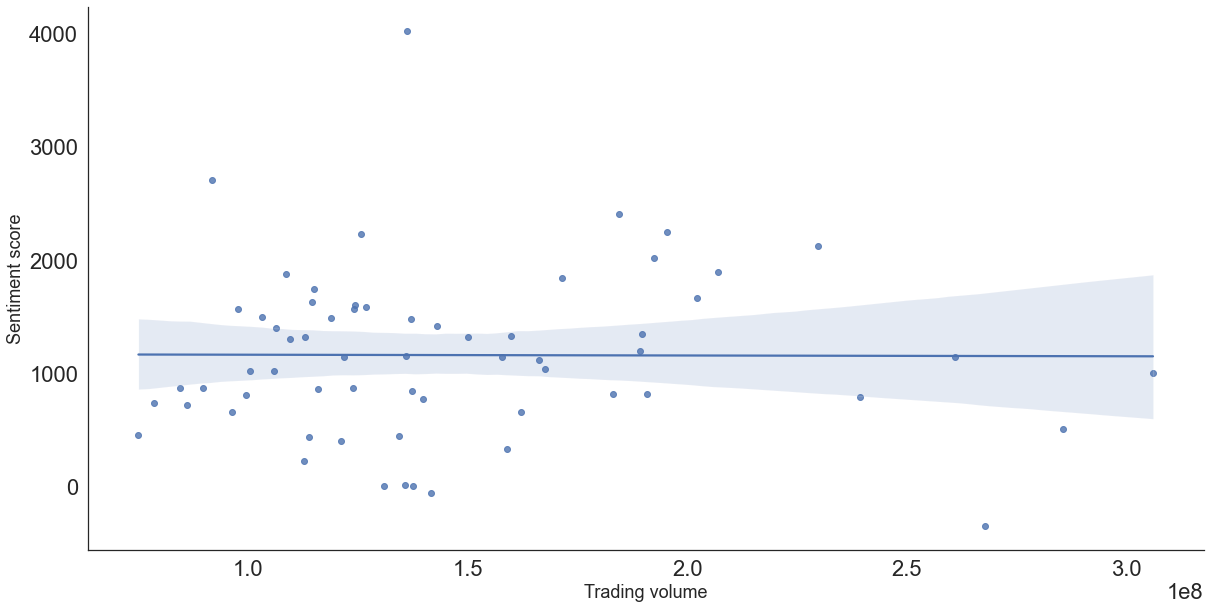

In [86]:
fig, ax=plt.subplots(figsize=(20,10))
ax=sns.regplot(x=stock_mean_sentiment.Volume, y=stock_mean_sentiment.Sentiment_score)
ax.set_xlabel('Trading volume', size=18)
ax.set_ylabel('Sentiment score', size=18);

### Stock Volume and sentiment score for previous month

**TODO:** Discuss how useful this plots might be for the datastory. Nothing special to see

In [90]:
stock_mean_sentiment_shifted = pd.merge(monthly_stock_mean, sentiment_shifted_df, how='inner', on = 'Date')

NameError: name 'sentiment_shifted_df' is not defined

In [91]:
stock_mean_sentiment_shifted

NameError: name 'stock_mean_sentiment_shifted' is not defined

NameError: name 'stock_mean_sentiment_shifted' is not defined

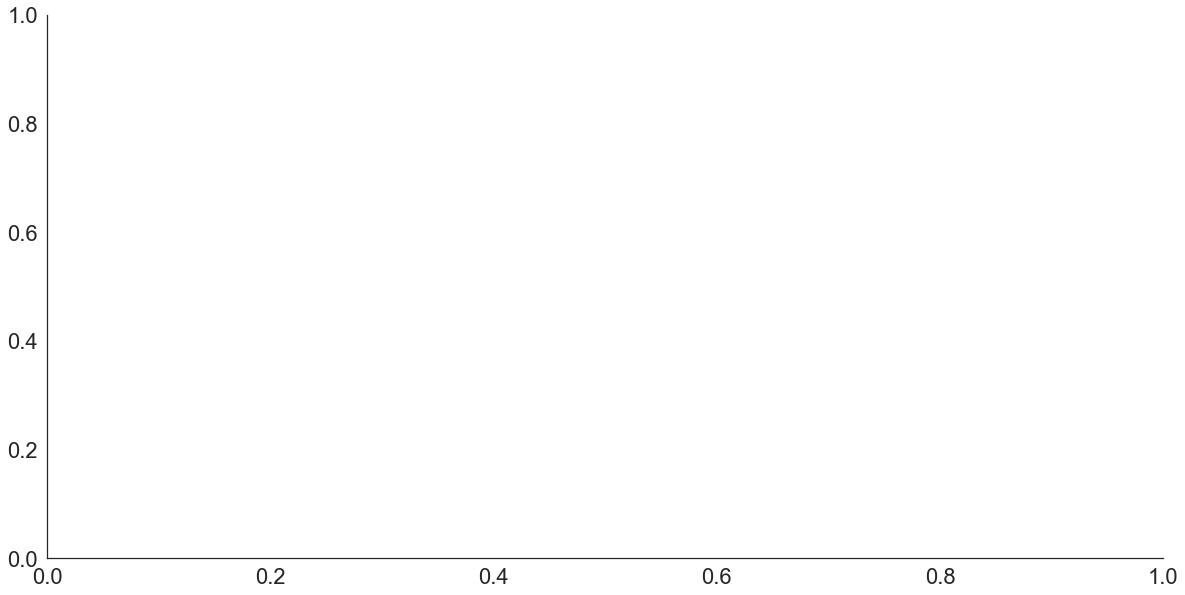

In [93]:
fig, ax=plt.subplots(figsize=(20,10))
ax=sns.regplot(x=stock_mean_sentiment_shifted.Volume, y=stock_mean_sentiment_shifted.Sentiment_score)
ax.set_xlabel('Trading volume', size=18)
ax.set_ylabel('Sentiment score', size=18);